In [1]:

import networkx as nx
import numpy as np
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Maxcut
# adapted from https://qiskit.org/ecosystem/optimization/tutorials/06_examples_max_cut_and_tsp.html

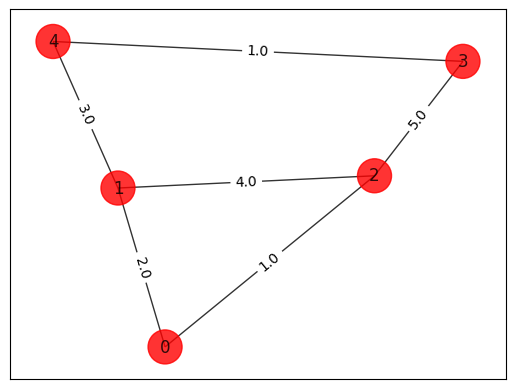

In [2]:
n = 5  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 2.0), (0, 2, 1.0), (1, 2, 4.0), (1, 4, 3.0), (2, 3, 5.0), (3, 4, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

node labels are off by one compared to the exercise sheet, counting starts at 0

In [3]:
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 2. 1. 0. 0.]
 [2. 0. 4. 0. 3.]
 [1. 4. 0. 5. 0.]
 [0. 0. 5. 0. 1.]
 [0. 3. 0. 1. 0.]]


Brute force solving the matrix classically:

case = [0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0, 0] cost = 9.0
case = [1, 1, 0, 0, 0] cost = 8.0
case = [0, 0, 1, 0, 0] cost = 10.0
case = [1, 0, 1, 0, 0] cost = 11.0
case = [0, 1, 1, 0, 0] cost = 11.0
case = [1, 1, 1, 0, 0] cost = 8.0
case = [0, 0, 0, 1, 0] cost = 6.0
case = [1, 0, 0, 1, 0] cost = 9.0
case = [0, 1, 0, 1, 0] cost = 15.0
case = [1, 1, 0, 1, 0] cost = 14.0
case = [0, 0, 1, 1, 0] cost = 6.0
case = [1, 0, 1, 1, 0] cost = 7.0
case = [0, 1, 1, 1, 0] cost = 7.0
case = [1, 1, 1, 1, 0] cost = 4.0
case = [0, 0, 0, 0, 1] cost = 4.0
case = [1, 0, 0, 0, 1] cost = 7.0
case = [0, 1, 0, 0, 1] cost = 7.0
case = [1, 1, 0, 0, 1] cost = 6.0
case = [0, 0, 1, 0, 1] cost = 14.0
case = [1, 0, 1, 0, 1] cost = 15.0
case = [0, 1, 1, 0, 1] cost = 9.0
case = [1, 1, 1, 0, 1] cost = 6.0
case = [0, 0, 0, 1, 1] cost = 8.0
case = [1, 0, 0, 1, 1] cost = 11.0
case = [0, 1, 0, 1, 1] cost = 11.0
case = [1, 1, 0, 1, 1] cost = 10.0
case = [0, 0, 1, 1, 1] cost = 8.0
case

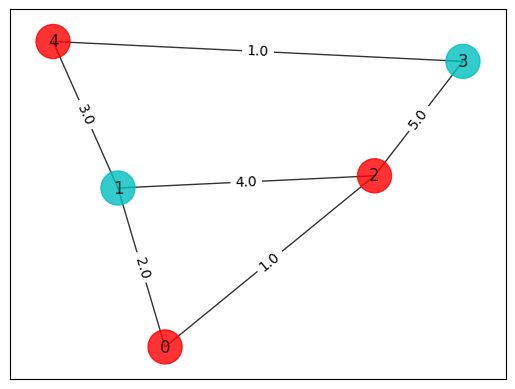

In [4]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

Qiskit already has Maxcut as a feature:

In [5]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -4*x_0*x_1 - 2*x_0*x_2 - 8*x_1*x_2 - 6*x_1*x_4 - 10*x_2*x_3 - 2*x_3*x_4
  + 3*x_0 + 9*x_1 + 10*x_2 + 6*x_3 + 4*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



In [6]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -8.0
Ising Hamiltonian:
1.0 * IIIZZ
+ 0.5 * IIZIZ
+ 2.0 * IIZZI
+ 2.5 * IZZII
+ 1.5 * ZIIZI
+ 0.5 * ZZIII


$$H = 1/2 (2 IIIZZ + IIZIZ + 4 IIZZI + 5 IZZII + 3 ZIIZI + ZZIII)$$
Each Hamiltonian part corresponds to a graph edge, and the qubit order is reversed from the node order.

energy: -7.0
max-cut objective: -15.0
solution: [0. 1. 0. 1. 0.]
solution objective: 15.0


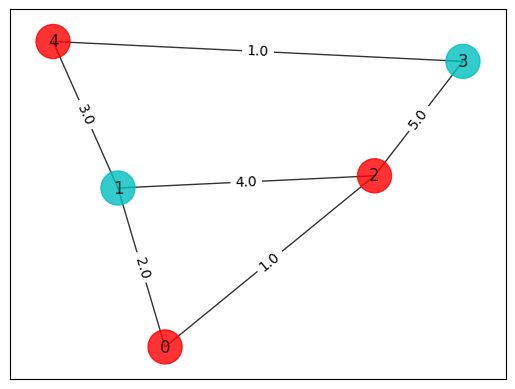

In [7]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

energy: -6.965462917669029
time: 36.742013931274414
max-cut objective: -14.96546291766903
solution: [0 1 0 1 0]
solution objective: 15.0


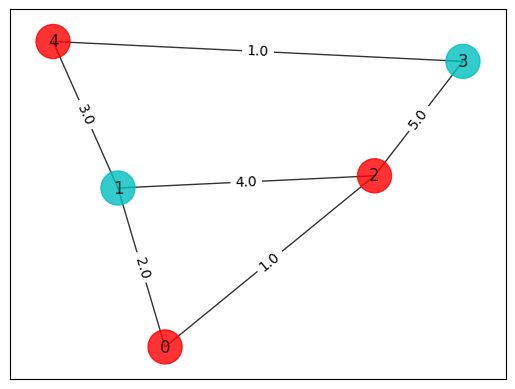

In [8]:
algorithm_globals.random_seed = 123
seed = 10598
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

objective function value: 15.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0
status: SUCCESS


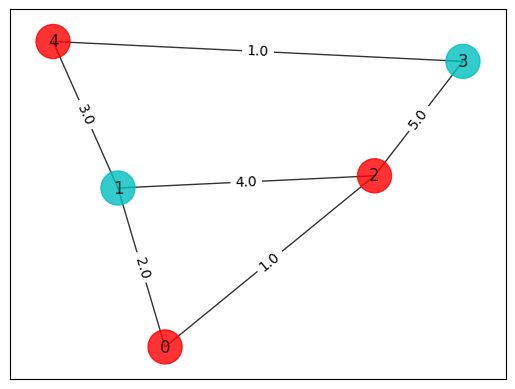

In [9]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

Task c): Hydrogen Molecule

I was not able to run it, it needs pyscf so it does not run on windows and on linux I ran into a segfault error.

In [1]:
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms.optimizers import SLSQP
from qiskit_aer.primitives import Estimator

qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt

In [17]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper



def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy", linestyle="none", marker="x")
plt.axvline(0.74)
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

MissingOptionalLibraryError: "The 'pyscf' library is required to use 'PySCFDriver'.  See https://pyscf.org/install.html."